## 1. Title & Description
**Lung Nodule Detection EDA**  
This notebook explores the LIDC-IDRI data:  
- Class balance  
- Example CT slices  
- Intensity distributions  

## 2. Imports

In [13]:
# %%
from io import StringIO, BytesIO

import io
import os
import glob
from aiohttp import ClientError
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sys

from dotenv import load_dotenv
from tqdm import tqdm
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

load_dotenv()

# load the labels for our images
s3_bucket_name = 'diabetic-retinopathy-project-2025'
prefix = 'Diabetic Retinopathy Screening AI.v1i.multiclass/'

ACCESS_KEY = os.getenv('ACCESS_KEY')
SECRET_KEY = os.getenv('SECRET_KEY')
s3 = boto3.client(
    's3',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    region_name='us-east-2'
)

response = s3.list_objects_v2(Bucket=s3_bucket_name, Prefix='Diabetic Retinopathy Screening AI.v1i.multiclass/')
paginator = s3.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket=s3_bucket_name, Prefix=prefix)

df_list = []

for page in page_iterator:
    for obj in page.get('Contents', []):
        key = obj['Key']
        if key.lower().endswith('.csv'):
            file_obj = s3.get_object(Bucket=s3_bucket_name, Key=key)
            csv_str = file_obj['Body'].read().decode('utf-8')
            df = pd.read_csv(StringIO(csv_str))
            df_list.append(df)

ann = pd.concat(df_list, ignore_index=True)

# set plots inline
%matplotlib inline

## 3. Load Annotations & Class Balance

<Axes: title={'center': 'Grouped Class Balance'}>

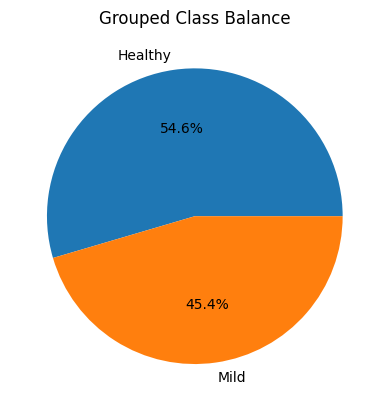

In [14]:
# class counts
ann = ann.rename(columns={
    " No_DR" : 0, 
    " Mild" : 1,
    " Moderate" : 1,
    " Proliferate_Dr" : 1,
    " Severe" : 1
})

ann = pd.melt(ann, id_vars=['filename'], 
              value_vars=[1, 0], 
              var_name='Diagnosis', value_name="Value")

ann = ann[ann["Value"] == 1].drop(columns="Value").reset_index(drop=True)

ann['grouped_label'] = ann['Diagnosis'].replace({
    0: 'Healthy',
    1: 'Mild',
    2: 'Moderate',
    3: 'Proliferate',
    4: 'Severe'
})

ann.to_csv("data/annotations_combined.csv", index=False)

counts = ann['grouped_label'].value_counts()

counts.plot.pie(autopct='%.1f%%', title='Grouped Class Balance', ylabel='')

## 4. Sample CT Slice Visualization

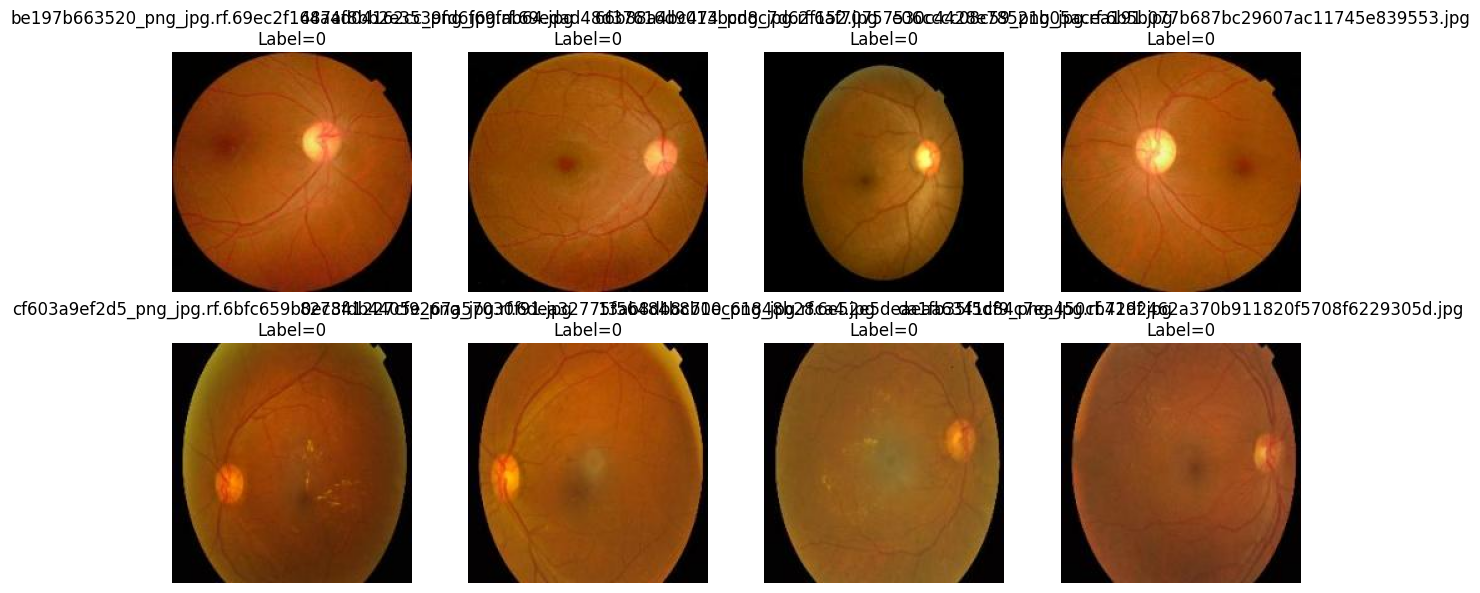

In [5]:
import io
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os


def load_s3_image(bucket, key):
    response = s3.get_object(Bucket=bucket, Key=key)
    img_bytes = response['Body'].read()
    return Image.open(io.BytesIO(img_bytes))

# Filter and sample IDs
pos_imgs = ann[ann['Diagnosis'] == 0]['filename'].values[:4]
neg_imgs = ann[ann['Diagnosis'].isin([1, 2, 3, 4])]['filename'].values[:4]

# Plotting
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Top row: Negatives (label=0)
for ax, fname in zip(axes[0], pos_imgs):
    img_path = prefix + fname
    img = load_s3_image(s3_bucket_name, img_path)
    ax.imshow(img)
    ax.set_title(f'{fname}\nLabel=0')
    ax.axis('off')

# Bottom row: Positives (label=1+)
for ax, fname in zip(axes[1], neg_imgs):
    img_path = prefix + fname
    img = load_s3_image(s3_bucket_name, img_path)
    ax.imshow(img)
    ax.set_title(f'{fname}\nLabel=0')
    ax.axis('off')

plt.tight_layout()
plt.show()


## 5. Pixel-Intensity Histogram

['be197b663520_png_jpg.rf.69ec2f1687af8bb2e3539fd6f69fab64.jpg', '44a4d04162cc_png_jpg.rf.69edad48d37616d9013bcd8c7d62f152.jpg', '66b88a4bc474_png_jpg.rf.6af70757530c4428e78521b05acea191.jpg', 'e06cccc08c59_png_jpg.rf.6b5b077b687bc29607ac11745e839553.jpg', 'cf603a9ef2d5_png_jpg.rf.6bfc659b0ec841227cf9267a57030f91.jpg', '8273fdb4405e_png_jpg.rf.6dea32775f56484b8b1ec61848b28ca4.jpg', '13ab8db8c700_png_jpg.rf.6e52e5deaeaa6341c84c7ea450cb419f.jpg', 'da1fb35f5df9_png_jpg.rf.72d2462a370b911820f5708f6229305d.jpg']


Text(0, 0.5, 'Frequency')

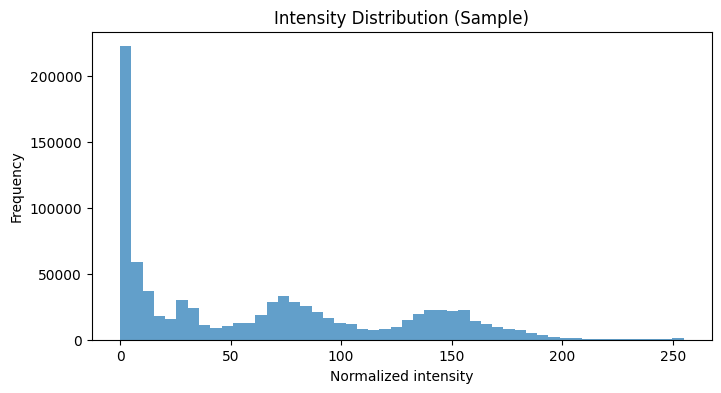

In [10]:
# gather intensities from a small sample to avoid huge memory usage
samples = pos_imgs.tolist() + neg_imgs.tolist()
print(samples)
pixels = []

for key in samples:
    obj = s3.get_object(Bucket=s3_bucket_name, Key=f'{prefix}{key}')
    img_bytes = obj['Body'].read()
    img = Image.open(BytesIO(img_bytes)).convert('RGB')
    img_array = np.array(img)                  # shape (H, W, 3)
    pixels.extend(img_array.flatten())  
    
plt.figure(figsize=(8,4))
plt.hist(pixels, bins=50, alpha=0.7)
plt.title('Intensity Distribution (Sample)')
plt.xlabel('Normalized intensity')
plt.ylabel('Frequency')

## 6. Quick Training Sanity Check 

In [15]:
from torch.utils.data import DataLoader
from src.dataloader import DRDataset
from src.model import DRClassifier

# small one-batch test
ds = DRDataset(df=ann, s3_client=s3, bucket_name=s3_bucket_name, prefix=prefix, transforms=None)
dl = DataLoader(ds, batch_size=4, shuffle=True)
imgs, labels = next(iter(dl))
model = DRClassifier(pretrained=False)
out = model(imgs)
print('Output shape:', out.shape)  # should be [4,2]

KEYSTER Diabetic Retinopathy Screening AI.v1i.multiclass/4f6abc40c72d_png_jpg.rf.45b1a59c3bf536700c7cb347e1750a34.jpg
KEYSTER Diabetic Retinopathy Screening AI.v1i.multiclass/c755a0c4edcc_png_jpg.rf.69ccb44b78bbe69ab78f828845a4e1b8.jpg
KEYSTER Diabetic Retinopathy Screening AI.v1i.multiclass/90b8bf342032_png_jpg.rf.3edf7687390ae2276ad6b20501099aea.jpg
KEYSTER Diabetic Retinopathy Screening AI.v1i.multiclass/78a577c3e0bf_png_jpg.rf.0ab26b0cefede4c7f34731c4ede2f699.jpg


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Output shape: torch.Size([4, 2])
